1. Setup & Imports
Import libraries (numpy, pandas, sklearn, matplotlib, logging, etc.)
Configure logging to file + console.

In [1]:
import os, json, warnings, logging, sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


2. Configuration
Define dataset path, target column, split ratios, CV folds, business costs.

In [2]:
CONFIG = {
    "dataset_path": "Final_Day/ecommerce_customer_behavior.csv",
    "target_col": "Customer_Type",
    "drop_cols": [],
    "type_overrides": {},
    "test_size": 0.15,
    "val_size": 0.15,
    "random_state": 42,
    "use_class_weight": True,
    "cv_folds": 5,
    "cost_fn": 10.0,
    "cost_fp": 2.0
}


3. Data Loading & Splitting
Load dataset.
Encode target labels.
Train/validation/test split.

In [4]:
# First split: train+val vs test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df.drop(columns=[CONFIG["target_col"]]),
    df[CONFIG["target_col"]],
    test_size=CONFIG["test_size"],
    random_state=CONFIG["random_state"],
    stratify=df[CONFIG["target_col"]]
)

# Second split: train vs val (relative to trainval size)
val_ratio_relative = CONFIG["val_size"] / (1.0 - CONFIG["test_size"])
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=val_ratio_relative,
    random_state=CONFIG["random_state"],
    stratify=y_trainval
)


4. Feature Engineering & Preprocessing
Detect categorical vs numeric features.
Build preprocessing pipelines (imputation, scaling, one-hot encoding).

In [5]:
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != CONFIG["target_col"]]
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != CONFIG["target_col"]]

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])


5. Model Setup & Hyperparameter Grids
Define models (LogReg, RF, GB, AdaBoost).
Define parameter grids for tuning.

In [6]:
models = {
    "logreg": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "rf": RandomForestClassifier(class_weight="balanced", random_state=CONFIG["random_state"]),
    "gb": GradientBoostingClassifier(random_state=CONFIG["random_state"]),
    "ada": AdaBoostClassifier(random_state=CONFIG["random_state"])
}

param_grids = {
    "logreg": {"model__C": [0.1, 1.0, 10.0]},
    "rf": {"model__n_estimators": [200, 500], "model__max_depth": [None, 8, 16]},
    "gb": {"model__n_estimators": [200, 400], "model__learning_rate": [0.05, 0.1]},
    "ada": {"model__n_estimators": [100, 300], "model__learning_rate": [0.5, 1.0]}
}


6. Training & Validation
Fit models with GridSearchCV.
Evaluate on validation set.
Select best model by PR-AUC.

In [7]:
results = []
best_model, best_grid, best_val_score = None, None, -np.inf

for key, model in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    cv = StratifiedKFold(n_splits=CONFIG["cv_folds"], shuffle=True, random_state=CONFIG["random_state"])
    grid = GridSearchCV(pipe, param_grids[key], cv=cv, scoring="average_precision", n_jobs=-1)
    grid.fit(X_train, y_train)

    val_proba = grid.predict_proba(X_val)[:, 1]
    pr_auc = average_precision_score(y_val, val_proba)

    if pr_auc > best_val_score:
        best_val_score, best_model, best_grid = pr_auc, key, grid

    results.append({"model": key, "best_params": grid.best_params_, "val_pr_auc": pr_auc})


/Users/amandeepsinghreen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/amandeepsinghreen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/amandeepsinghreen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/amandeepsinghreen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/amandeepsinghreen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in 

7. Test Evaluation & Business Threshold Optimization
Sweep thresholds to minimize expected business cost.
Compare metrics at default (0.5) vs optimized threshold.

In [8]:
test_proba = best_grid.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0, 1, 51)
costs = [(fp*CONFIG["cost_fp"] + fn*CONFIG["cost_fn"]) / len(y_test)
         for thr in thresholds
         for tn, fp, fn, tp in [confusion_matrix(y_test, (test_proba >= thr).astype(int)).ravel()]]

best_thr = thresholds[np.argmin(costs)]


8. Visualization
ROC curve, PR curve.
Business cost vs threshold curve.

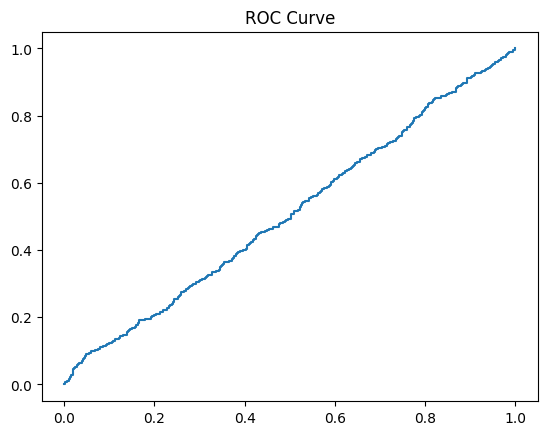

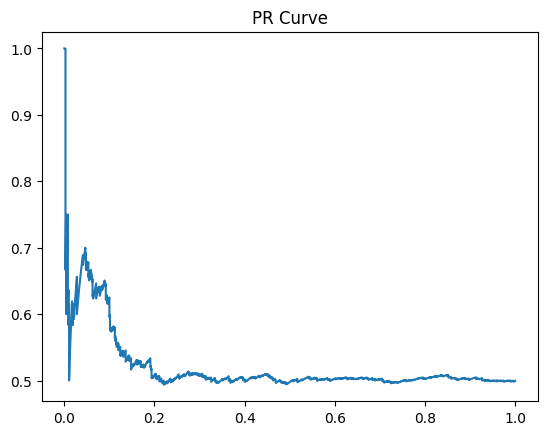

In [9]:
fpr, tpr, _ = roc_curve(y_test, test_proba)
precision, recall, _ = precision_recall_curve(y_test, test_proba)

plt.plot(fpr, tpr); plt.title("ROC Curve"); plt.show()
plt.plot(recall, precision); plt.title("PR Curve"); plt.show()


9. Permutation Importance
Compute feature importance on validation set.
Save top features.

In [10]:
final_pipe = best_grid.best_estimator_
final_pipe.fit(X_train, y_train)
result = permutation_importance(final_pipe, X_val, y_val, n_repeats=5, random_state=CONFIG["random_state"])


10. Save Artifacts
Save importance CSV, model results JSON, trained model with joblib.

In [11]:
import joblib
joblib.dump(final_pipe, f"artifacts/{best_model}_model.joblib")


['artifacts/rf_model.joblib']